=== LSTM version 1 - Original features only ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build flexible time window data set for LSTM with original features...
Time range analysis:
  Earliest date in data: 2020-09-04
  Latest date in data: 2021-02-10
  Earliest predict date: 2020-09-11 (Day 8)

=== Data availability statistics ===
Prediction day statistics:
  Total days in data: 2398
  Days satisfying the time window requirement: 4131
  Actual days with data: 2290
  Prediction day utilizati

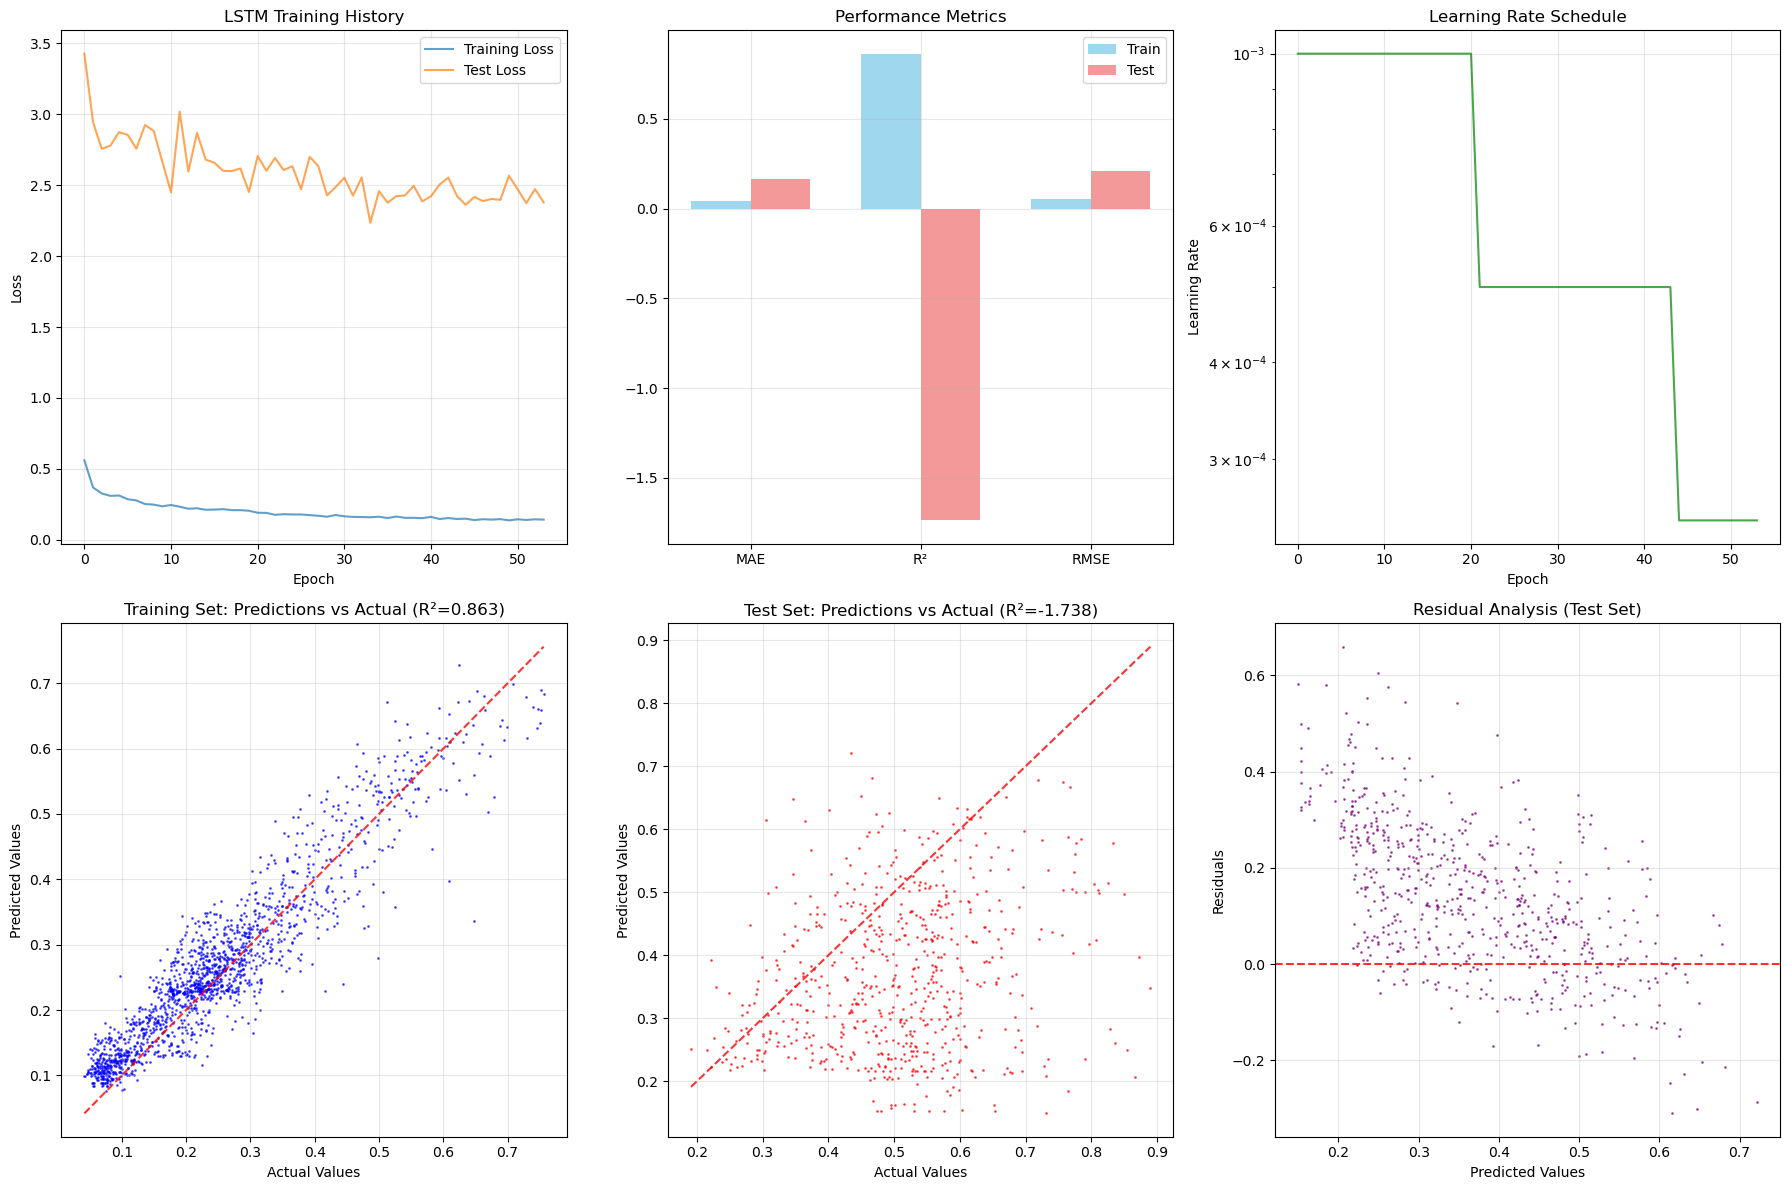

Visualization completed and saved.

10. Saving results...
Results saved:
  - Model: ../models/lstm_version_1_original_features.pth
  - Training history: ../results/lstm_version_1_original_features_training_history.csv
  - Predictions: ../results/lstm_version_1_predictions.csv
  - Metrics: ../results/lstm_version_1_original_features_metrics_summary.csv
  - Visualization: ../results/lstm_version_1_original_features.png

LSTM Version 1 model training completed (original features only)
Feature composition:
  - Time series features: 15 features/day × 7 days = 105 time series features
    * Original wastewater features: 15 features/day
  - Total input features: 105

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensuring a complete history window
  ✓ Strict 7-day time window, never use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to maintain time logic
  ✓ Include only original wastewater detection features
  ✓ LSTM architecture optimized 

In [1]:
##### LSTM version 1 - Original features only

print("=== LSTM version 1 - Original features only ===")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import os
from datetime import datetime, timedelta
from torch.utils.data import TensorDataset, DataLoader
warnings.filterwarnings('ignore')

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Prepare flexible time window data for LSTM (original features only)
print("\n2. Build flexible time window data set for LSTM with original features...")

def create_flexible_time_window_lstm_original(data, window_days=7):
    """
    Create flexible time window data set for LSTM, containing:
    - Original features (15 features) within the last window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    """
    
    sequences = []
    targets = []
    dates = []
    cis_codes = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Use real data
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features)
                        day_features = hist_row[original_features].values
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = np.zeros(len(original_features))
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Reverse to get chronological order (oldest to newest)
                sequence_features = np.array(sequence_features[::-1])  # shape: (7, 15)
                
                sequences.append(sequence_features)
                targets.append(pred_target)
                dates.append(current_date)
                cis_codes.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, 7, 15)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data in history: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    return sequences, targets, np.array(dates), np.array(cis_codes)

# Create dataset
sequences, targets, sample_dates, sample_cis = create_flexible_time_window_lstm_original(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 15)
print(f"  Target vector: {targets.shape}")
print(f"  Total number of samples: {len(targets)}")

# Feature composition analysis
print(f"\n=== Feature composition ===")
print(f"Time series features (each sample):")
print(f"  - 7 days ago: 15 original features")
print(f"  - 6 days ago: 15 original features")
print(f"  - 5 days ago: 15 original features")
print(f"  - 4 days ago: 15 original features")
print(f"  - 3 days ago: 15 original features")
print(f"  - 2 days ago: 15 original features")
print(f"  - 1 day ago: 15 original features")
print(f"  Total input: 15 features × 7 timesteps = 105 total features")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the 8th day of the data, ensuring a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: Use 0 to fill in the history window if there is no data")
print(f"✓ Time boundary: Never use data from the prediction day or future")
print(f"✓ Feature completeness: Include only original wastewater features")

# Example of time logic validation
print(f"\n=== Example of time logic validation ===")
if len(sample_dates) > 0:
    # Show the time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Feature shape: {sequences[i].shape}")  # Should be (7, 15)
        print()

# Validate no future data is used
print(f"=== Time safety validation ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: Earliest prediction day is at least 8 days from the start of the data")

# 3. Time-based split
print("\n3. Time-based split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
test_sequences = sequences[test_mask]
test_targets = targets[test_mask]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")
print(f"Training data shape: {train_sequences.shape}")  # (n_train, 7, 15)
print(f"Test data shape: {test_sequences.shape}")      # (n_test, 7, 15)

# 4. Feature standardization
print("\n4. Feature standardization...")

# For sequence features, we need to standardize each feature dimension across all samples and timesteps
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Reshape sequences for standardization: (n_samples, timesteps, features) -> (n_samples * timesteps, features)
n_train, n_timesteps, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_timesteps, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_timesteps, n_features)

# Standardize targets
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")
print(f"Standardized training data shape: {train_seq_scaled.shape}")
print(f"Standardized test data shape: {test_seq_scaled.shape}")
print(f"Features per timestep: {n_features}")  # Should be 15

# 5. Define LSTM model (Version 1 - original features only)
print("\n5. Define LSTM model architecture...")

class LSTMOriginalFeatures(nn.Module):
    """LSTM model for predicting infection rates using only original wastewater features"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMOriginalFeatures, self).__init__()
        
        self.input_size = input_size      # 15 features per timestep
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Output layers
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize LSTM weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
        # Initialize linear layer weights
        for layer in self.output_layer:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """
        Forward pass
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
        Returns:
            output: Prediction tensor of shape (batch_size,)
        """
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the output from the last timestep
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Pass through output layers
        output = self.output_layer(last_output)
        
        return output.squeeze()  # (batch_size,)

# Create model instance
model = LSTMOriginalFeatures(
    input_size=n_features,  # 15 features
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"Model created with:")
print(f"  Input size: {n_features} features per timestep")
print(f"  Hidden size: 64")
print(f"  Number of layers: 2")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Print model architecture
print(f"\nModel architecture:")
print(model)

# 6. Training setup and data preparation
print("\n6. Training setup...")

# Convert to PyTorch tensors
train_sequences_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_targets_tensor = torch.FloatTensor(train_targets_scaled).to(device)
test_sequences_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_targets_tensor = torch.FloatTensor(test_targets_scaled).to(device)

print(f"Training data tensor shape: {train_sequences_tensor.shape}")
print(f"Training targets tensor shape: {train_targets_tensor.shape}")
print(f"Test data tensor shape: {test_sequences_tensor.shape}")
print(f"Test targets tensor shape: {test_targets_tensor.shape}")

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training settings
num_epochs = 200
batch_size = 32
early_stopping_patience = 20
best_test_loss = float('inf')
early_stop_counter = 0

print(f"Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-4")
print(f"  Early stopping patience: {early_stopping_patience}")

# Training history tracking
train_losses = []
test_losses = []
learning_rates = []

# 7. Training loop
print("\n7. Start training...")

train_dataset = TensorDataset(train_sequences_tensor, train_targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training started...")
start_time = datetime.now()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_sequences, batch_targets in train_loader:
        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_sequences_tensor)
        test_loss = criterion(test_outputs, test_targets_tensor)
        test_losses.append(test_loss.item())
    
    # Learning rate scheduling
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Check if learning rate was reduced
    if current_lr < prev_lr:
        print(f"Learning rate reduced from {prev_lr:.6f} to {current_lr:.6f}")
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
        # Save best model
        torch.save(model.state_dict(), '../models/lstm_version_1_original_features.pth')
    else:
        early_stop_counter += 1
    
    # Print progress
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        elapsed_time = datetime.now() - start_time
        print(f'Epoch [{epoch:3d}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}, '
              f'Time: {elapsed_time}')
    
    # Early stopping check
    if early_stop_counter >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f"\nTraining completed!")
print(f"Best test loss: {best_test_loss:.4f}")
print(f"Total training time: {datetime.now() - start_time}")

# Load best model for evaluation
model.load_state_dict(torch.load('../models/lstm_version_1_original_features.pth'))
model.eval()

# 8. Model evaluation and predictions
print("\n8. Model evaluation...")

# Make predictions
with torch.no_grad():
    # Training set predictions
    train_pred_scaled = model(train_sequences_tensor).cpu().numpy()
    # Test set predictions
    test_pred_scaled = model(test_sequences_tensor).cpu().numpy()

# Inverse transform predictions and targets to original scale
train_pred_orig = scaler_target.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
test_pred_orig = scaler_target.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_targets, train_pred_orig)
train_r2 = r2_score(train_targets, train_pred_orig)
train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))

test_mae = mean_absolute_error(test_targets, test_pred_orig)
test_r2 = r2_score(test_targets, test_pred_orig)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))

print("\n=== Model Performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# Calculate additional metrics
print(f"\nAdditional metrics:")
print(f"  Train set size: {len(train_targets)}")
print(f"  Test set size: {len(test_targets)}")
print(f"  Target range: [{targets.min():.4f}, {targets.max():.4f}]")
print(f"  Mean target value: {targets.mean():.4f}")
print(f"  Test predictions range: [{test_pred_orig.min():.4f}, {test_pred_orig.max():.4f}]")

# 9. Visualization
print("\n9. Creating visualizations...")

plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.7)
axes[0, 0].plot(test_losses, label='Test Loss', alpha=0.7)
axes[0, 0].set_title('LSTM Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='lightcoral')
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate history
axes[0, 2].plot(learning_rates, alpha=0.7, color='green')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual - training set
axes[1, 0].scatter(train_targets, train_pred_orig, alpha=0.6, s=1, color='blue')
axes[1, 0].plot([train_targets.min(), train_targets.max()], 
                [train_targets.min(), train_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predictions vs actual - test set
axes[1, 1].scatter(test_targets, test_pred_orig, alpha=0.6, s=1, color='red')
axes[1, 1].plot([test_targets.min(), test_targets.max()], 
                [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = test_targets - test_pred_orig
axes[1, 2].scatter(test_pred_orig, test_residuals, alpha=0.6, s=1, color='purple')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_version_1_original_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved.")

# 10. Save results and model artifacts
print("\n10. Saving results...")

# Save training history
training_history = pd.DataFrame({
    'epoch': range(len(train_losses)),
    'train_loss': train_losses,
    'test_loss': test_losses,
    'learning_rate': learning_rates
})
training_history.to_csv('../results/lstm_version_1_original_features_training_history.csv', index=False)

# Save predictions
test_dates_list = [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]]
test_cis_list = [sample_cis[i] for i in range(len(sample_cis)) if test_mask[i]]

predictions_df = pd.DataFrame({
    'actual': test_targets,
    'predicted': test_pred_orig,
    'residual': test_targets - test_pred_orig,
    'date': test_dates_list,
    'cis_code': test_cis_list
})
predictions_df.to_csv('../results/lstm_version_1_predictions.csv', index=False)

# Save metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['LSTM_v1_OriginalFeatures'],
    'train_mae': [train_mae],
    'train_r2': [train_r2],
    'train_rmse': [train_rmse],
    'test_mae': [test_mae],
    'test_r2': [test_r2],
    'test_rmse': [test_rmse],
    'feature_count': [n_features * n_timesteps],  # 15 * 7 = 105
    'sequence_length': [n_timesteps],  # 7
    'features_per_timestep': [n_features],  # 15
    'sample_count': [len(test_targets)],
    'total_epochs': [len(train_losses)],
    'best_test_loss': [best_test_loss]
})
metrics_summary.to_csv('../results/lstm_version_1_original_features_metrics_summary.csv', index=False)

print("Results saved:")
print(f"  - Model: ../models/lstm_version_1_original_features.pth")
print(f"  - Training history: ../results/lstm_version_1_original_features_training_history.csv")
print(f"  - Predictions: ../results/lstm_version_1_predictions.csv")
print(f"  - Metrics: ../results/lstm_version_1_original_features_metrics_summary.csv")
print(f"  - Visualization: ../results/lstm_version_1_original_features.png")

print("\n" + "="*80)
print("LSTM Version 1 model training completed (original features only)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 15 features/day × 7 days = 105 time series features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"  - Total input features: {n_features * n_timesteps}")

print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensuring a complete history window")
print(f"  ✓ Strict 7-day time window, never use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to maintain time logic")
print(f"  ✓ Include only original wastewater detection features")
print(f"  ✓ LSTM architecture optimized for sequential time series data")

print(f"\nModel architecture:")
print(f"  ✓ Input size: {n_features} features per timestep")
print(f"  ✓ Sequence length: {n_timesteps} days")
print(f"  ✓ Hidden size: 64")
print(f"  ✓ Number of LSTM layers: 2")
print(f"  ✓ Dropout: 0.3")
print(f"  ✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"  ✓ Training completed in {len(train_losses)} epochs")

print(f"\nTime safety validation:")
print(f"  ✓ Earliest prediction day is {(min_pred_date - data['date'].min()).days} days from data start")
print(f"  ✓ No future data leakage - only uses past 7 days for prediction")
print(f"  ✓ Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print("="*80)


=== LSTM version 2 - Include past 7-day infection rate features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

Additional feature:
  16. median_prob (historical infection rate)

2. Build flexible time window data set for LSTM with infection rates...
Time range analysis:
  Earliest date in data: 2020-09-04
  Latest date in data: 2021-02-10
  Earliest predict date: 2020-09-11 (Day 8)

=== Data availability statistics ===
Prediction day statistics:
  Total days in data: 2398
  Days satisfying the t

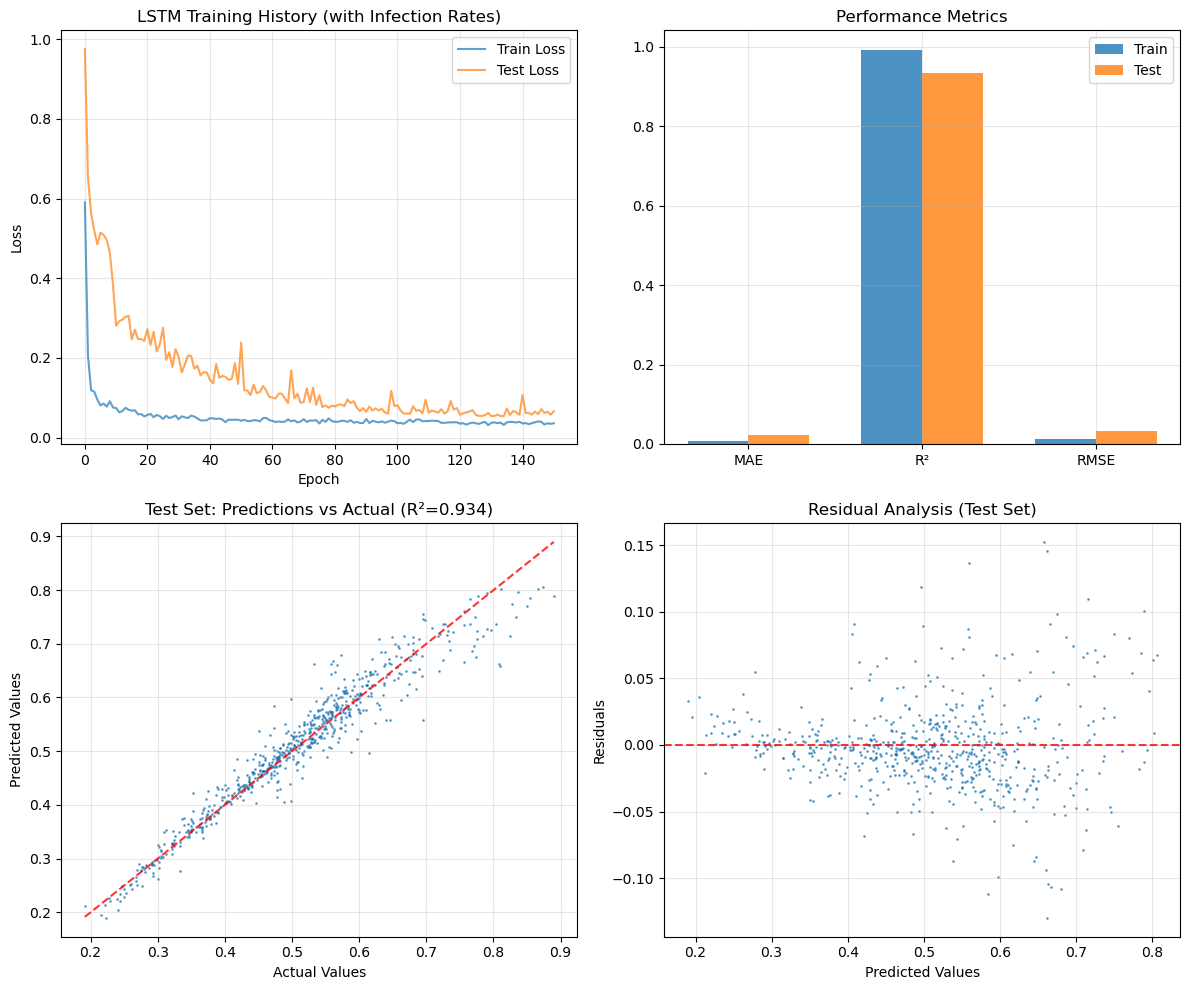


9. Save results...
Results saved:
  - Model: ../models/lstm_version_2_with_infection_rates.pth
  - Predictions: ../results/lstm_version_2_predictions.csv
  - Training history: ../results/lstm_version_2_training_history.csv
  - Metrics summary: ../results/lstm_version_2_metrics_summary.csv
  - Visualization: ../results/lstm_version_2_with_infection_rates.png

LSTM model version 2 training completed (flexible time window + include past 7-day infection rate features)
Feature composition:
  - Time series features: 16 features/day × 7 days = 112 features
    * Original wastewater features: 15 features/day
    * Historical infection rate: 1 feature/day
  - Input to LSTM: sequence of 7 timesteps, each with 16 features
  - Model architecture: 2-layer LSTM with 64 hidden units

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 

In [2]:
##### LSTM version 2 - Include past 7-day infection rate features

print("=== LSTM version 2 - Include past 7-day infection rate features ===")

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nAdditional feature:")
print(f"  16. median_prob (historical infection rate)")

# 2. Prepare flexible time window data for LSTM (include past 7-day infection rate features)
print("\n2. Build flexible time window data set for LSTM with infection rates...")

def create_flexible_time_window_lstm_with_infection_rates(data, window_days=7):
    """
    Create flexible time window data set for LSTM, containing:
    - Original features (15 features) within the last window_days days
    - Historical infection rate (1 feature) within the last window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    """
    
    sequences = []
    targets = []
    dates = []
    cis_codes = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Use real data
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = list(hist_row[original_features].values) + [hist_row['median_prob']]
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = [0.0] * (len(original_features) + 1)  # 16 zeros
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Reverse to get chronological order (oldest to newest)
                sequence_features = np.array(sequence_features[::-1])  # shape: (7, 16)
                
                sequences.append(sequence_features)
                targets.append(pred_target)
                dates.append(current_date)
                cis_codes.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, 7, 16)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data in history: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    return sequences, targets, np.array(dates), np.array(cis_codes)

# Create dataset
sequences, targets, sample_dates, sample_cis = create_flexible_time_window_lstm_with_infection_rates(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 16)
print(f"  Target vector: {targets.shape}")
print(f"  Total number of samples: {len(targets)}")

# Feature composition analysis
print(f"\n=== Feature composition ===")
print(f"Time series features (for each sample):")
print(f"  - Day t-7 to t-1: 15 original features + 1 infection rate = 16 features per day")
print(f"  - Total: 16 × 7 = 112 time series features")

print(f"\n=== Strategy verification ===")
print(f"✓ Include original features + historical infection rate")
print(f"✓ Chronological sequence order for LSTM")

# Example of time logic validation
print(f"\n=== Example of time logic validation ===")
if len(sample_dates) > 0:
    # Show the time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Feature shape: {sequences[i].shape}")  # Should be (7, 16)
        print()

# 3. Time split
print("\n3. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
test_sequences = sequences[test_mask]
test_targets = targets[test_mask]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")

# 4. Feature standardization
print("\n4. Feature standardization...")
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Standardize sequence features
n_train, n_timesteps, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_timesteps, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_timesteps, n_features)

# Standardize target
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print(f"Features per timestep: {n_features} (15 original + 1 infection rate)")

# 5. LSTM model definition
print("\n5. Define LSTM model with infection rates...")

class LSTMWithInfectionRates(nn.Module):
    """LSTM model - original wastewater features + historical infection rates"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMWithInfectionRates, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Output layers
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1
                n = param.size(0)
                param.data[(n//4):(n//2)].fill_(1)
    
    def forward(self, x):
        """x: (batch_size, sequence_length, input_size)"""
        batch_size = x.size(0)
        
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Final prediction
        output = self.output_layer(last_output)
        
        return output.squeeze()

# Model parameters
input_size = n_features  # 16 features (15 original + 1 infection rate)
hidden_size = 64
num_layers = 2
dropout = 0.3

print(f"Input size: {input_size} (15 original + 1 infection rate)")

# Create model
model = LSTMWithInfectionRates(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 6. Model training
print("\n6. LSTM model training with infection rates...")

# Convert to tensors
train_seq_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_target_tensor = torch.FloatTensor(train_targets_scaled).to(device)
test_seq_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_target_tensor = torch.FloatTensor(test_targets_scaled).to(device)

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training settings
num_epochs = 200
batch_size = 32
patience = 20
best_test_loss = float('inf')
early_stop_counter = 0
train_losses = []
test_losses = []

print(f"Training data shape: {train_seq_tensor.shape}")
print(f"Starting training...")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    num_batches = 0
    
    # Create batches
    for i in range(0, len(train_seq_tensor), batch_size):
        batch_end = min(i + batch_size, len(train_seq_tensor))
        batch_seq = train_seq_tensor[i:batch_end]
        batch_target = train_target_tensor[i:batch_end]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_seq)
        loss = criterion(outputs, batch_target)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = epoch_train_loss / num_batches
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_seq_tensor)
        test_loss = criterion(test_outputs, test_target_tensor)
    
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    
    # Learning rate scheduling
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    if current_lr < prev_lr:
        print(f"Learning rate reduced from {prev_lr:.6f} to {current_lr:.6f}")
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), '../models/lstm_version_2_with_infection_rates.pth')
    else:
        early_stop_counter += 1
    
    # Print progress
    if epoch % 20 == 0 or epoch < 10:
        print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    # Early stopping check
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"Training completed! Best test loss: {best_test_loss:.4f}")

# 7. Model evaluation and results
print("\n7. Model evaluation...")

# Load best model
model.load_state_dict(torch.load('../models/lstm_version_2_with_infection_rates.pth'))
model.eval()

with torch.no_grad():
    # Predictions
    train_pred_scaled = model(train_seq_tensor)
    test_pred_scaled = model(test_seq_tensor)
    
    # Inverse transform to original scale
    train_pred = scaler_target.inverse_transform(train_pred_scaled.cpu().numpy().reshape(-1, 1)).flatten()
    test_pred = scaler_target.inverse_transform(test_pred_scaled.cpu().numpy().reshape(-1, 1)).flatten()

# Calculate metrics
train_mae = mean_absolute_error(train_targets, train_pred)
train_r2 = r2_score(train_targets, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred))

test_mae = mean_absolute_error(test_targets, test_pred)
test_r2 = r2_score(test_targets, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred))

print("=== LSTM Model Performance (with infection rates) ===")
print(f"Training set: MAE: {train_mae:.4f}, R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test set: MAE: {test_mae:.4f}, R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

# 8. Visualization
print("\n8. Result visualization...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training history
epochs_range = range(len(train_losses))
axes[0, 0].plot(epochs_range, train_losses, label='Train Loss', alpha=0.7)
axes[0, 0].plot(epochs_range, test_losses, label='Test Loss', alpha=0.7)
axes[0, 0].set_title('LSTM Training History (with Infection Rates)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Predictions vs actual - test set
axes[1, 0].scatter(test_targets, test_pred, alpha=0.6, s=1)
axes[1, 0].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Residual analysis
test_residuals = test_targets - test_pred
axes[1, 1].scatter(test_pred, test_residuals, alpha=0.6, s=1)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_title('Residual Analysis (Test Set)')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_version_2_with_infection_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Save results
print("\n9. Save results...")

# Save predictions
results_df = pd.DataFrame({
    'actual': test_targets,
    'predicted': test_pred,
    'residual': test_targets - test_pred,
    'date': sample_dates[test_mask],
    'cis_code': sample_cis[test_mask]
})
results_df.to_csv('../results/lstm_version_2_predictions.csv', index=False)

# Save training history
history_df = pd.DataFrame({
    'epoch': range(len(train_losses)),
    'train_loss': train_losses,
    'test_loss': test_losses
})
history_df.to_csv('../results/lstm_version_2_training_history.csv', index=False)

# Save model metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['LSTM_With_Infection_Rates'],
    'input_size': [input_size],
    'hidden_size': [hidden_size],
    'num_layers': [num_layers],
    'total_parameters': [sum(p.numel() for p in model.parameters())],
    'train_samples': [len(train_targets)],
    'test_samples': [len(test_targets)],
    'train_mae': [train_mae],
    'train_r2': [train_r2],
    'train_rmse': [train_rmse],
    'test_mae': [test_mae],
    'test_r2': [test_r2],
    'test_rmse': [test_rmse],
    'best_test_loss': [best_test_loss.item() if torch.is_tensor(best_test_loss) else best_test_loss],
    'epochs_trained': [len(train_losses)],
    'feature_composition': ['15_original + 1_infection_rate']
})
metrics_summary.to_csv('../results/lstm_version_2_metrics_summary.csv', index=False)

print("Results saved:")
print("  - Model: ../models/lstm_version_2_with_infection_rates.pth")
print("  - Predictions: ../results/lstm_version_2_predictions.csv")
print("  - Training history: ../results/lstm_version_2_training_history.csv")
print("  - Metrics summary: ../results/lstm_version_2_metrics_summary.csv")
print("  - Visualization: ../results/lstm_version_2_with_infection_rates.png")

print("\n" + "="*80)
print("LSTM model version 2 training completed (flexible time window + include past 7-day infection rate features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 16 features/day × 7 days = 112 features")
print(f"    * Original wastewater features: 15 features/day")
print(f"    * Historical infection rate: 1 feature/day")
print(f"  - Input to LSTM: sequence of 7 timesteps, each with 16 features")
print(f"  - Model architecture: {num_layers}-layer LSTM with {hidden_size} hidden units")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Chronological sequence order for LSTM (oldest to newest)")
print(f"  ✓ Bidirectional=False to prevent future information leakage")
print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"  ✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*80)


=== LSTM version 3 - Include past 7-day infection rate features + infection rate derived features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

Additional features:
  16. median_prob (historical infection rate)
  17-27. Derived features based on past 7-day infection rates (11 features)

2. Define infection rate derived features calculation...

Infection rate derived features (11 features):
   1. infection_rate_mean_7d
   2. infection_rate_std_7d
   3. infection_rate_max_7d
   4. infection_rate_

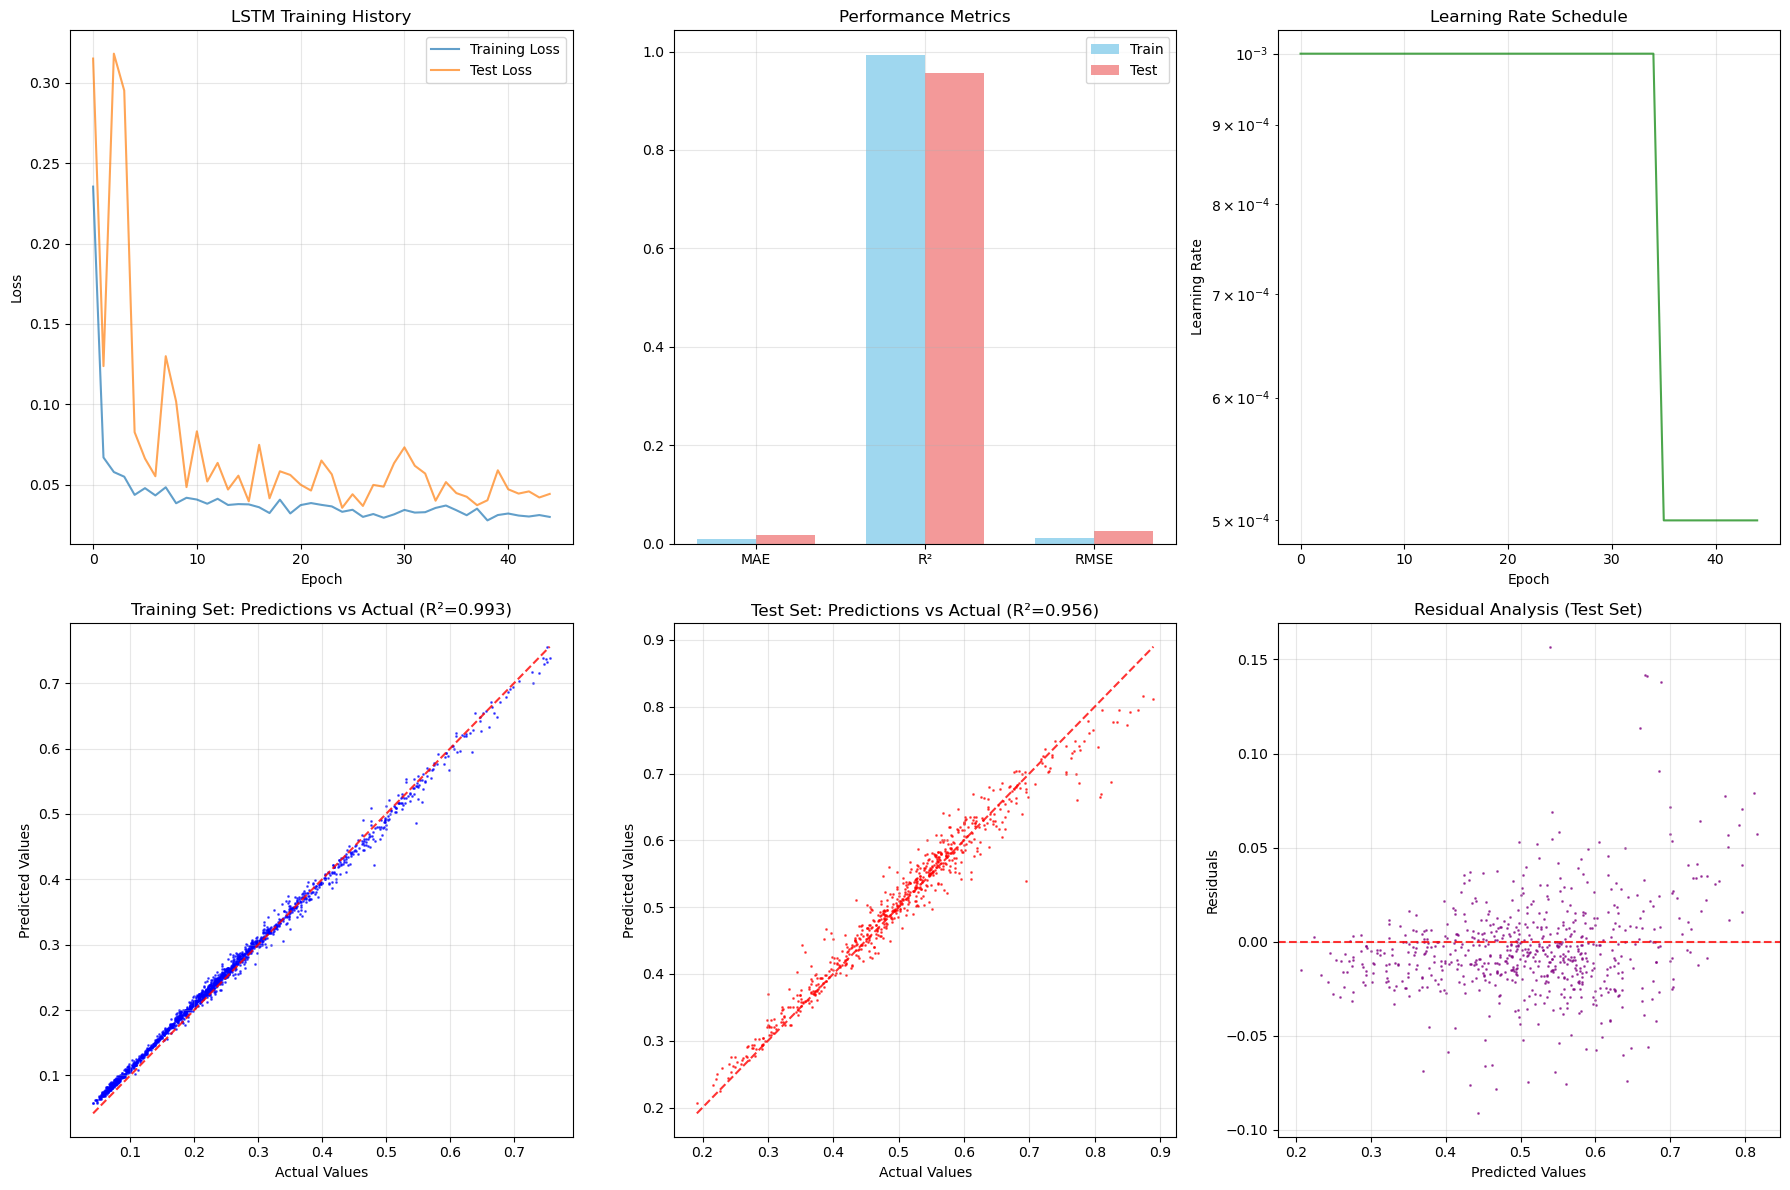

Visualization completed and saved.

11. Saving results...
Results saved:
  - Model: ../models/lstm_version_3_with_infection_rates_derived.pth
  - Training history: ../results/lstm_version_3_infection_rates_derived_training_history.csv
  - Predictions: ../results/lstm_version_3_predictions.csv
  - Metrics: ../results/lstm_version_3_infection_rates_derived_metrics_summary.csv
  - Visualization: ../results/lstm_version_3_with_infection_rates_derived.png

LSTM Version 3 model training completed (with infection rates and derived features)
Feature composition:
  - Time series features: 27 features/day × 7 days = 189 time series features
    * Original wastewater features: 15 features/day
    * Historical infection rate features: 1 feature/day
    * Infection rate derived features: 11 features/day
  - Total input features: 189

Infection rate derived features (11 features):
   1. infection_rate_mean_7d
   2. infection_rate_std_7d
   3. infection_rate_trend_7d
   4. infection_rate_max_7d
   5.

In [4]:
##### LSTM version 3 - Include past 7-day infection rate features + infection rate derived features

print("=== LSTM version 3 - Include past 7-day infection rate features + infection rate derived features ===")


print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nAdditional features:")
print(f"  16. median_prob (historical infection rate)")
print(f"  17-27. Derived features based on past 7-day infection rates (11 features)")

# 2. Infection rate derived features calculation function
print("\n2. Define infection rate derived features calculation...")

def calculate_infection_rate_derived_features(infection_rates, availability_flags):
    """
    Calculate derived features based on past 7 days infection rates
    
    Parameters:
    - infection_rates: list of infection rates for the past 7 days [day1, day2, ..., day7] (most recent to oldest)
    - availability_flags: list of data availability flags corresponding to the infection rates
    
    Returns:
    - derived features dictionary (11 features)
    """
    # Only use infection rates with data
    valid_rates = [rate for rate, flag in zip(infection_rates, availability_flags) if flag == 1]
    
    derived_features = {}
    
    if len(valid_rates) == 0:
        # If there is no valid data, all derived features are 0
        derived_features = {
            'infection_rate_mean_7d': 0.0,
            'infection_rate_std_7d': 0.0,
            'infection_rate_trend_7d': 0.0,
            'infection_rate_max_7d': 0.0,
            'infection_rate_min_7d': 0.0,
            'infection_rate_range_7d': 0.0,
            'infection_rate_recent_3d_mean': 0.0,
            'infection_rate_change_1d': 0.0,
            'infection_rate_change_3d': 0.0,
            'infection_rate_volatility_7d': 0.0,
            'infection_rate_momentum_7d': 0.0
        }
    else:
        # Basic statistical features
        derived_features['infection_rate_mean_7d'] = np.mean(valid_rates)
        derived_features['infection_rate_std_7d'] = np.std(valid_rates) if len(valid_rates) > 1 else 0.0
        derived_features['infection_rate_max_7d'] = np.max(valid_rates)
        derived_features['infection_rate_min_7d'] = np.min(valid_rates)
        derived_features['infection_rate_range_7d'] = derived_features['infection_rate_max_7d'] - derived_features['infection_rate_min_7d']
        
        # Trend features (linear regression slope)
        if len(valid_rates) >= 2:
            x = np.arange(len(valid_rates))
            slope, _ = np.polyfit(x, valid_rates, 1)
            derived_features['infection_rate_trend_7d'] = slope
        else:
            derived_features['infection_rate_trend_7d'] = 0.0
        
        # Recent features (mean of the past 3 days)
        recent_3d_rates = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
        derived_features['infection_rate_recent_3d_mean'] = np.mean(recent_3d_rates) if recent_3d_rates else 0.0
        
        # Change features
        if len(valid_rates) >= 2:
            # 1 day change (today - yesterday)
            if availability_flags[0] == 1 and availability_flags[1] == 1:
                derived_features['infection_rate_change_1d'] = infection_rates[0] - infection_rates[1]
            else:
                derived_features['infection_rate_change_1d'] = 0.0
            
            # 3 day change (mean of the past 3 days - mean of the past 4-6 days)
            recent_3d = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
            earlier_3d = [rate for rate, flag in zip(infection_rates[3:6], availability_flags[3:6]) if flag == 1]
            
            if recent_3d and earlier_3d:
                derived_features['infection_rate_change_3d'] = np.mean(recent_3d) - np.mean(earlier_3d)
            else:
                derived_features['infection_rate_change_3d'] = 0.0
        else:
            derived_features['infection_rate_change_1d'] = 0.0
            derived_features['infection_rate_change_3d'] = 0.0
        
        # Volatility features (relative standard deviation)
        if derived_features['infection_rate_mean_7d'] > 0:
            derived_features['infection_rate_volatility_7d'] = derived_features['infection_rate_std_7d'] / derived_features['infection_rate_mean_7d']
        else:
            derived_features['infection_rate_volatility_7d'] = 0.0
        
        # Momentum features (weighted average, recent days have higher weight)
        if len(valid_rates) >= 3:
            weights = np.array([0.4, 0.3, 0.2, 0.1][:len(valid_rates)])
            weights = weights / weights.sum()
            derived_features['infection_rate_momentum_7d'] = np.average(valid_rates[:len(weights)], weights=weights)
        else:
            derived_features['infection_rate_momentum_7d'] = derived_features['infection_rate_mean_7d']
    
    return derived_features

# Test the function and display derived features
print("\nInfection rate derived features (11 features):")
sample_derived = calculate_infection_rate_derived_features([0.1]*7, [1]*7)
for i, feature_name in enumerate(sample_derived.keys(), 1):
    print(f"  {i:2d}. {feature_name}")

print(f"\nTotal features per timestep: 15 original + 1 infection rate + 11 derived = 27 features")

# 3. Prepare flexible time window data for LSTM (include infection rates + derived features)
print("\n3. Build flexible time window data set for LSTM with infection rates and derived features...")

def create_flexible_time_window_lstm_with_infection_rates_and_derived(data, window_days=7):
    """
    Create flexible time window data set for LSTM, containing:
    - Original features (15 features) within the last window_days days
    - Historical infection rate (1 feature) within the last window_days days
    - Derived features based on past 7-day infection rates (11 features)
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    5. Derived features are completely based on historical infection rate data
    """
    
    sequences = []
    targets = []
    dates = []
    cis_codes = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions
    all_cis = sorted(data['CIS20CD'].unique())
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                infection_rates_history = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Use real data
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = list(hist_row[original_features].values) + [hist_row['median_prob']]
                        day_availability.append(1)  # Mark as data available
                        infection_rates_history.append(hist_row['median_prob'])
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = [0.0] * (len(original_features) + 1)  # 16 zeros
                        day_availability.append(0)  # Mark as no data
                        infection_rates_history.append(0.0)
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Calculate infection rate derived features (based on historical 7 days data)
                derived_features = calculate_infection_rate_derived_features(
                    infection_rates_history, day_availability
                )
                
                # Add derived features to each day's features
                derived_feature_values = list(derived_features.values())  # 11 derived features
                
                # Add derived features to each day
                enhanced_sequence_features = []
                for day_features in sequence_features:
                    enhanced_day_features = day_features + derived_feature_values  # 16 + 11 = 27 features
                    enhanced_sequence_features.append(enhanced_day_features)
                
                # Reverse to get chronological order (oldest to newest)
                enhanced_sequence_features = np.array(enhanced_sequence_features[::-1])  # shape: (7, 27)
                
                sequences.append(enhanced_sequence_features)
                targets.append(pred_target)
                dates.append(current_date)
                cis_codes.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, 7, 27)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data in history: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    return sequences, targets, np.array(dates), np.array(cis_codes)

# Create dataset
sequences, targets, sample_dates, sample_cis = create_flexible_time_window_lstm_with_infection_rates_and_derived(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 27)
print(f"  Target vector: {targets.shape}")
print(f"  Total number of samples: {len(targets)}")

# Feature composition analysis
print(f"\n=== Feature composition ===")
print(f"Time series features (each sample):")
print(f"  - 7 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 6 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 5 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 4 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 3 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 2 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 1 day ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  Total input: 27 features × 7 timesteps = 189 total features")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the 8th day of the data, ensuring a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: Use 0 to fill in the history window if there is no data")
print(f"✓ Time boundary: Never use data from the prediction day or future")
print(f"✓ Feature completeness: Include original features + historical infection rates + derived features")
print(f"✓ Derived features: Fully based on past 7-day infection rates")

# Example of time logic validation
print(f"\n=== Example of time logic validation ===")
if len(sample_dates) > 0:
    # Show the time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_cis[i]}")
        print(f"  Feature shape: {sequences[i].shape}")  # Should be (7, 27)
        print()

# Validate no future data is used
print(f"=== Time safety validation ===")
min_pred_date = sample_dates.min()
max_pred_date = sample_dates.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: Earliest prediction day is at least 8 days from the start of the data")

# 4. Time-based split
print("\n4. Time-based split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
test_sequences = sequences[test_mask]
test_targets = targets[test_mask]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")
print(f"Training data shape: {train_sequences.shape}")  # (n_train, 7, 27)
print(f"Test data shape: {test_sequences.shape}")      # (n_test, 7, 27)

# 5. Feature standardization
print("\n5. Feature standardization...")

# For sequence features, we need to standardize each feature dimension across all samples and timesteps
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Reshape sequences for standardization: (n_samples, timesteps, features) -> (n_samples * timesteps, features)
n_train, n_timesteps, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_timesteps, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_timesteps, n_features)

# Standardize targets
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")
print(f"Standardized training data shape: {train_seq_scaled.shape}")
print(f"Standardized test data shape: {test_seq_scaled.shape}")
print(f"Features per timestep: {n_features}")  # Should be 27

# 6. Define LSTM model (Version 3 - with infection rates and derived features)
print("\n6. Define LSTM model architecture...")

class LSTMWithInfectionRatesAndDerived(nn.Module):
    """LSTM model for predicting infection rates using wastewater data, historical infection rates, and derived features"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMWithInfectionRatesAndDerived, self).__init__()
        
        self.input_size = input_size      # 27 features per timestep
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Output layers
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize LSTM weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
        # Initialize linear layer weights
        for layer in self.output_layer:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """
        Forward pass
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
        Returns:
            output: Prediction tensor of shape (batch_size,)
        """
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the output from the last timestep
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Pass through output layers
        output = self.output_layer(last_output)
        
        return output.squeeze()  # (batch_size,)

# Create model instance
model = LSTMWithInfectionRatesAndDerived(
    input_size=n_features,  # 27 features
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"Model created with:")
print(f"  Input size: {n_features} features per timestep")
print(f"  Hidden size: 64")
print(f"  Number of layers: 2")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Print model architecture
print(f"\nModel architecture:")
print(model)

# 7. Training setup and data preparation
print("\n7. Training setup...")

# Convert to PyTorch tensors
train_sequences_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_targets_tensor = torch.FloatTensor(train_targets_scaled).to(device)
test_sequences_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_targets_tensor = torch.FloatTensor(test_targets_scaled).to(device)

print(f"Training data tensor shape: {train_sequences_tensor.shape}")
print(f"Training targets tensor shape: {train_targets_tensor.shape}")
print(f"Test data tensor shape: {test_sequences_tensor.shape}")
print(f"Test targets tensor shape: {test_targets_tensor.shape}")

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training settings
num_epochs = 200
batch_size = 32
early_stopping_patience = 20
best_test_loss = float('inf')
early_stop_counter = 0

print(f"Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-4")
print(f"  Early stopping patience: {early_stopping_patience}")

# Training history tracking
train_losses = []
test_losses = []
learning_rates = []

# 8. Training loop
print("\n8. Start training...")

train_dataset = TensorDataset(train_sequences_tensor, train_targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training started...")
start_time = datetime.now()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_sequences, batch_targets in train_loader:
        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_sequences_tensor)
        test_loss = criterion(test_outputs, test_targets_tensor)
        test_losses.append(test_loss.item())
    
    # Learning rate scheduling
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Check if learning rate was reduced
    if current_lr < prev_lr:
        print(f"Learning rate reduced from {prev_lr:.6f} to {current_lr:.6f}")
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
        # Save best model
        torch.save(model.state_dict(), '../models/lstm_version_3_with_infection_rates_derived.pth')
    else:
        early_stop_counter += 1
    
    # Print progress
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        elapsed_time = datetime.now() - start_time
        print(f'Epoch [{epoch:3d}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}, '
              f'Time: {elapsed_time}')
    
    # Early stopping check
    if early_stop_counter >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f"\nTraining completed!")
print(f"Best test loss: {best_test_loss:.4f}")
print(f"Total training time: {datetime.now() - start_time}")

# Load best model for evaluation
model.load_state_dict(torch.load('../models/lstm_version_3_with_infection_rates_derived.pth'))
model.eval()

# 9. Model evaluation and predictions
print("\n9. Model evaluation...")

# Make predictions
with torch.no_grad():
    # Training set predictions
    train_pred_scaled = model(train_sequences_tensor).cpu().numpy()
    # Test set predictions
    test_pred_scaled = model(test_sequences_tensor).cpu().numpy()

# Inverse transform predictions and targets to original scale
train_pred_orig = scaler_target.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
test_pred_orig = scaler_target.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_targets, train_pred_orig)
train_r2 = r2_score(train_targets, train_pred_orig)
train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))

test_mae = mean_absolute_error(test_targets, test_pred_orig)
test_r2 = r2_score(test_targets, test_pred_orig)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))

print("\n=== Model Performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# Calculate additional metrics
print(f"\nAdditional metrics:")
print(f"  Train set size: {len(train_targets)}")
print(f"  Test set size: {len(test_targets)}")
print(f"  Target range: [{targets.min():.4f}, {targets.max():.4f}]")
print(f"  Mean target value: {targets.mean():.4f}")
print(f"  Test predictions range: [{test_pred_orig.min():.4f}, {test_pred_orig.max():.4f}]")

# 10. Visualization
print("\n10. Creating visualizations...")

plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.7)
axes[0, 0].plot(test_losses, label='Test Loss', alpha=0.7)
axes[0, 0].set_title('LSTM Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='lightcoral')
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate history
axes[0, 2].plot(learning_rates, alpha=0.7, color='green')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual - training set
axes[1, 0].scatter(train_targets, train_pred_orig, alpha=0.6, s=1, color='blue')
axes[1, 0].plot([train_targets.min(), train_targets.max()], 
                [train_targets.min(), train_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predictions vs actual - test set
axes[1, 1].scatter(test_targets, test_pred_orig, alpha=0.6, s=1, color='red')
axes[1, 1].plot([test_targets.min(), test_targets.max()], 
                [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = test_targets - test_pred_orig
axes[1, 2].scatter(test_pred_orig, test_residuals, alpha=0.6, s=1, color='purple')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_version_3_with_infection_rates_derived.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved.")

# 11. Save results and model artifacts
print("\n11. Saving results...")

# Save training history
training_history = pd.DataFrame({
    'epoch': range(len(train_losses)),
    'train_loss': train_losses,
    'test_loss': test_losses,
    'learning_rate': learning_rates
})
training_history.to_csv('../results/lstm_version_3_infection_rates_derived_training_history.csv', index=False)

# Save predictions
test_dates_list = [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]]
test_cis_list = [sample_cis[i] for i in range(len(sample_cis)) if test_mask[i]]

predictions_df = pd.DataFrame({
    'actual': test_targets,
    'predicted': test_pred_orig,
    'residual': test_targets - test_pred_orig,
    'date': test_dates_list,
    'cis_code': test_cis_list
})
predictions_df.to_csv('../results/lstm_version_3_predictions.csv', index=False)

# Save metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['LSTM_v3_InfectionRates_Derived'],
    'train_mae': [train_mae],
    'train_r2': [train_r2],
    'train_rmse': [train_rmse],
    'test_mae': [test_mae],
    'test_r2': [test_r2],
    'test_rmse': [test_rmse],
    'feature_count': [n_features * n_timesteps],  # 27 * 7 = 189
    'sequence_length': [n_timesteps],  # 7
    'features_per_timestep': [n_features],  # 27
    'sample_count': [len(test_targets)],
    'total_epochs': [len(train_losses)],
    'best_test_loss': [best_test_loss]
})
metrics_summary.to_csv('../results/lstm_version_3_infection_rates_derived_metrics_summary.csv', index=False)

print("Results saved:")
print(f"  - Model: ../models/lstm_version_3_with_infection_rates_derived.pth")
print(f"  - Training history: ../results/lstm_version_3_infection_rates_derived_training_history.csv")
print(f"  - Predictions: ../results/lstm_version_3_predictions.csv")
print(f"  - Metrics: ../results/lstm_version_3_infection_rates_derived_metrics_summary.csv")
print(f"  - Visualization: ../results/lstm_version_3_with_infection_rates_derived.png")

print("\n" + "="*80)
print("LSTM Version 3 model training completed (with infection rates and derived features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 27 features/day × 7 days = 189 time series features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"    * Historical infection rate features: 1 feature/day")
print(f"    * Infection rate derived features: 11 features/day")
print(f"  - Total input features: {n_features * n_timesteps}")

print(f"\nInfection rate derived features (11 features):")
derived_feature_names = [
    'infection_rate_mean_7d', 'infection_rate_std_7d', 'infection_rate_trend_7d',
    'infection_rate_max_7d', 'infection_rate_min_7d', 'infection_rate_range_7d',
    'infection_rate_recent_3d_mean', 'infection_rate_change_1d', 'infection_rate_change_3d',
    'infection_rate_volatility_7d', 'infection_rate_momentum_7d'
]
for i, feature_name in enumerate(derived_feature_names, 1):
    print(f"  {i:2d}. {feature_name}")

print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensuring a complete history window")
print(f"  ✓ Strict 7-day time window, never use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include 11 derived features based on historical infection rates")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ LSTM architecture optimized for sequential time series data")

print(f"\nModel architecture:")
print(f"  ✓ Input size: {n_features} features per timestep")
print(f"  ✓ Sequence length: {n_timesteps} days")
print(f"  ✓ Hidden size: 64")
print(f"  ✓ Number of LSTM layers: 2")
print(f"  ✓ Dropout: 0.3")
print(f"  ✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"  ✓ Training completed in {len(train_losses)} epochs")

print(f"\nTime safety validation:")
print(f"  ✓ Earliest prediction day is {(min_pred_date - data['date'].min()).days} days from data start")
print(f"  ✓ No future data leakage - only uses past 7 days for prediction")
print(f"  ✓ Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print("="*80)


=== LSTM version 4 - Include past 7-day infection rate features + infection rate derived features + socio-economic features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27
Number of matching CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

Socio-economic features (5 features):
  1. IMD_Score
  2. Population_Density
  3. Elderly_Ratio
  4. Overcrowding_Rate
  5. Ethnic_Diversity_Index

Additional features:
  16. median_prob (historical infection rate)
  17-27. Derived features based on past 7-day infection rates (11 features)
  2

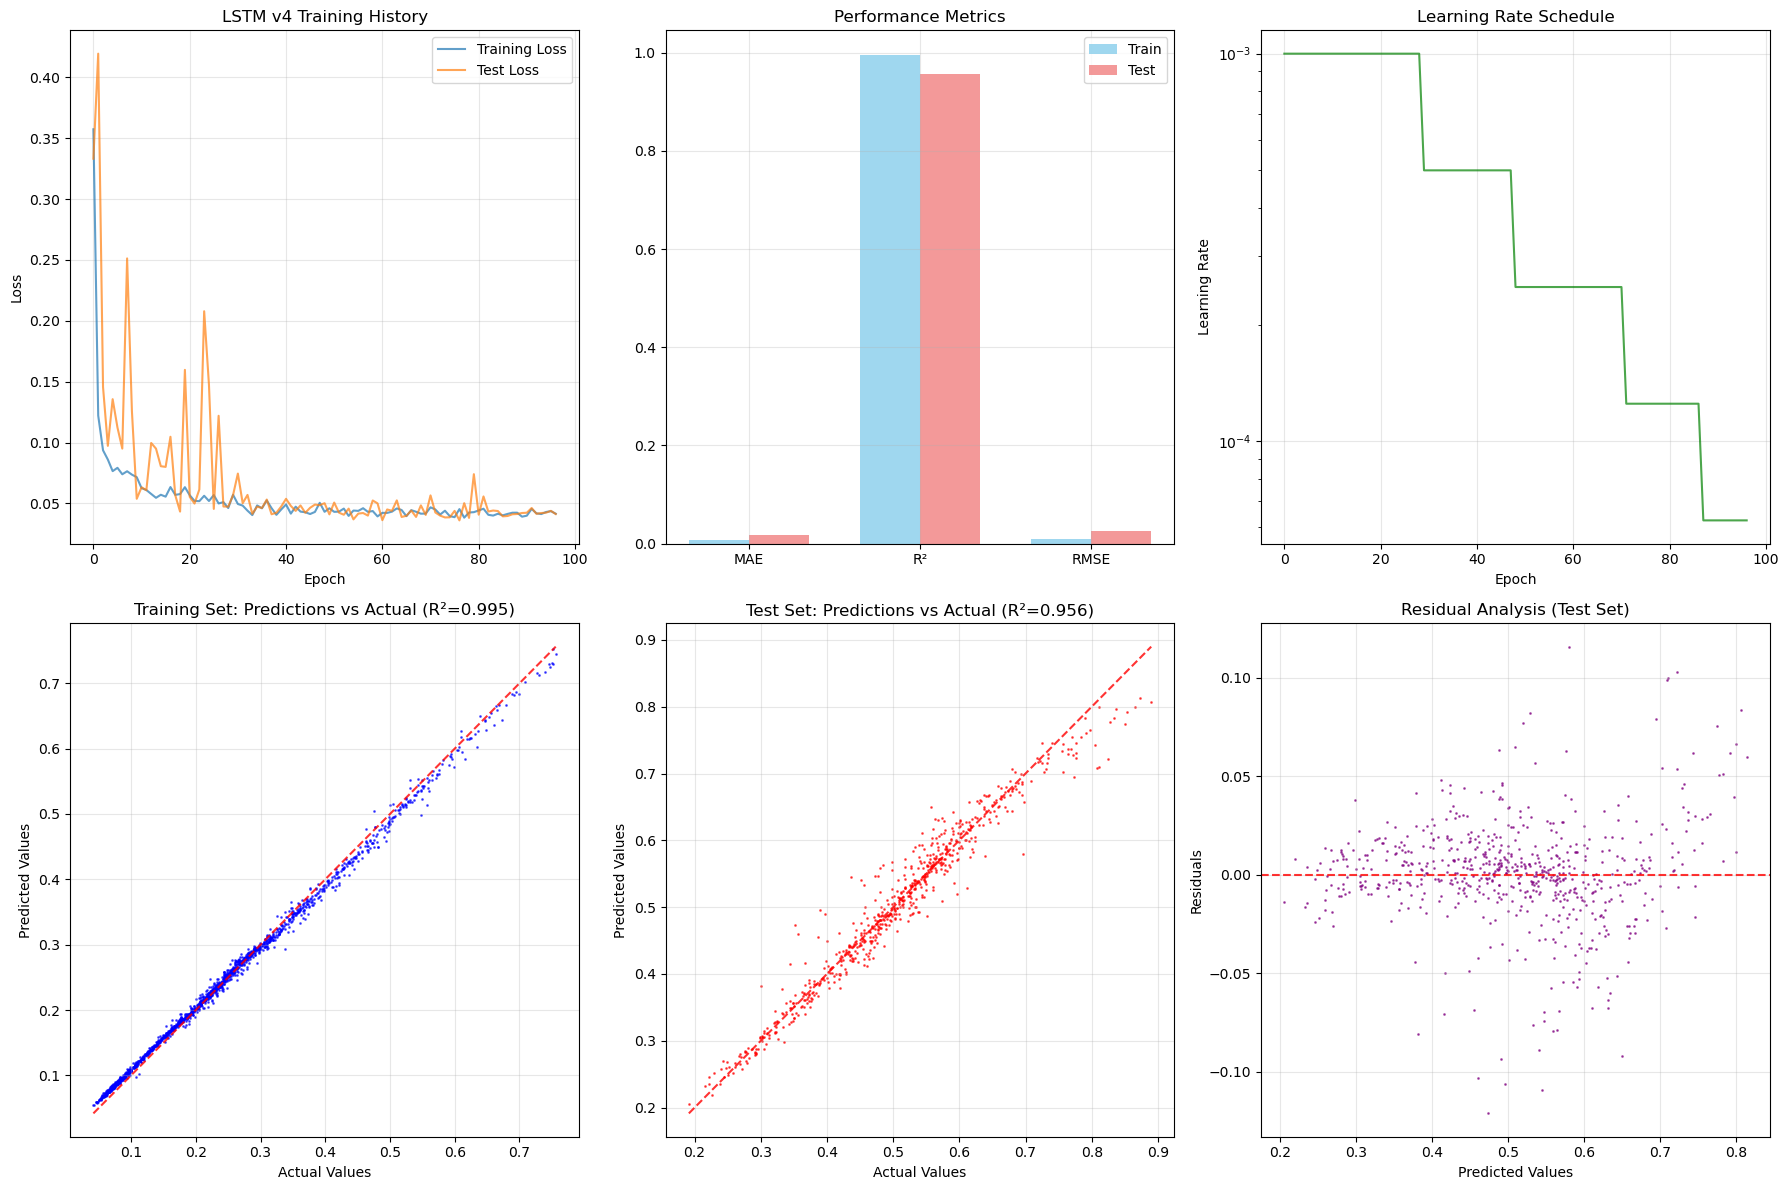

Visualization completed and saved.

11. Saving results...
Results saved:
  - Model: ../models/lstm_version_4_with_all_features_derived.pth
  - Training history: ../results/lstm_version_4_all_features_derived_training_history.csv
  - Predictions: ../results/lstm_version_4_predictions.csv
  - Metrics: ../results/lstm_version_4_all_features_derived_metrics_summary.csv
  - Visualization: ../results/lstm_version_4_with_all_features_derived.png

LSTM Version 4 model training completed (with all features including socio-economic)
Feature composition:
  - Time series features: 27 features/day × 7 days = 189 time series features
    * Original wastewater features: 15 features/day
    * Historical infection rate features: 1 feature/day
    * Infection rate derived features: 11 features/day
  - Socio-economic features: 5 static features
  - Total input features: 194

Infection rate derived features (11 features):
   1. infection_rate_mean_7d
   2. infection_rate_std_7d
   3. infection_rate_trend_

In [5]:
##### LSTM version 4 - Include past 7-day infection rate features + infection rate derived features + socio-economic features

print("=== LSTM version 4 - Include past 7-day infection rate features + infection rate derived features + socio-economic features ===")

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')
socio_data = pd.read_csv('../data/processed/cis_socio_economic_data.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
socio_cis = socio_data['CIS20CD'].unique()
common_cis = set(cis_regions) & set(socio_cis)

print(f"Number of CIS regions: {len(cis_regions)}")
print(f"Number of matching CIS regions: {len(common_cis)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

# Socio-economic features (5 features)
socio_features = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nSocio-economic features ({len(socio_features)} features):")
for i, feat in enumerate(socio_features, 1):
    print(f"  {i}. {feat}")

print(f"\nAdditional features:")
print(f"  16. median_prob (historical infection rate)")
print(f"  17-27. Derived features based on past 7-day infection rates (11 features)")
print(f"  28-32. Socio-economic features (5 static features)")

# 2. Infection rate derived features calculation function
print("\n2. Define infection rate derived features calculation...")

def calculate_infection_rate_derived_features(infection_rates, availability_flags):
    """
    Calculate derived features based on past 7 days infection rates
    
    Parameters:
    - infection_rates: list of infection rates for the past 7 days [day1, day2, ..., day7] (most recent to oldest)
    - availability_flags: list of data availability flags corresponding to the infection rates
    
    Returns:
    - derived features dictionary (11 features)
    """
    # Only use infection rates with data
    valid_rates = [rate for rate, flag in zip(infection_rates, availability_flags) if flag == 1]
    
    derived_features = {}
    
    if len(valid_rates) == 0:
        # If there is no valid data, all derived features are 0
        derived_features = {
            'infection_rate_mean_7d': 0.0,
            'infection_rate_std_7d': 0.0,
            'infection_rate_trend_7d': 0.0,
            'infection_rate_max_7d': 0.0,
            'infection_rate_min_7d': 0.0,
            'infection_rate_range_7d': 0.0,
            'infection_rate_recent_3d_mean': 0.0,
            'infection_rate_change_1d': 0.0,
            'infection_rate_change_3d': 0.0,
            'infection_rate_volatility_7d': 0.0,
            'infection_rate_momentum_7d': 0.0
        }
    else:
        # Basic statistical features
        derived_features['infection_rate_mean_7d'] = np.mean(valid_rates)
        derived_features['infection_rate_std_7d'] = np.std(valid_rates) if len(valid_rates) > 1 else 0.0
        derived_features['infection_rate_max_7d'] = np.max(valid_rates)
        derived_features['infection_rate_min_7d'] = np.min(valid_rates)
        derived_features['infection_rate_range_7d'] = derived_features['infection_rate_max_7d'] - derived_features['infection_rate_min_7d']
        
        # Trend features (linear regression slope)
        if len(valid_rates) >= 2:
            x = np.arange(len(valid_rates))
            slope, _ = np.polyfit(x, valid_rates, 1)
            derived_features['infection_rate_trend_7d'] = slope
        else:
            derived_features['infection_rate_trend_7d'] = 0.0
        
        # Recent features (mean of the past 3 days)
        recent_3d_rates = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
        derived_features['infection_rate_recent_3d_mean'] = np.mean(recent_3d_rates) if recent_3d_rates else 0.0
        
        # Change features
        if len(valid_rates) >= 2:
            # 1 day change (today - yesterday)
            if availability_flags[0] == 1 and availability_flags[1] == 1:
                derived_features['infection_rate_change_1d'] = infection_rates[0] - infection_rates[1]
            else:
                derived_features['infection_rate_change_1d'] = 0.0
            
            # 3 day change (mean of the past 3 days - mean of the past 4-6 days)
            recent_3d = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
            earlier_3d = [rate for rate, flag in zip(infection_rates[3:6], availability_flags[3:6]) if flag == 1]
            
            if recent_3d and earlier_3d:
                derived_features['infection_rate_change_3d'] = np.mean(recent_3d) - np.mean(earlier_3d)
            else:
                derived_features['infection_rate_change_3d'] = 0.0
        else:
            derived_features['infection_rate_change_1d'] = 0.0
            derived_features['infection_rate_change_3d'] = 0.0
        
        # Volatility features (relative standard deviation)
        if derived_features['infection_rate_mean_7d'] > 0:
            derived_features['infection_rate_volatility_7d'] = derived_features['infection_rate_std_7d'] / derived_features['infection_rate_mean_7d']
        else:
            derived_features['infection_rate_volatility_7d'] = 0.0
        
        # Momentum features (weighted average, recent days have higher weight)
        if len(valid_rates) >= 3:
            weights = np.array([0.4, 0.3, 0.2, 0.1][:len(valid_rates)])
            weights = weights / weights.sum()
            derived_features['infection_rate_momentum_7d'] = np.average(valid_rates[:len(weights)], weights=weights)
        else:
            derived_features['infection_rate_momentum_7d'] = derived_features['infection_rate_mean_7d']
    
    return derived_features

# Test the function and display derived features
print("\nInfection rate derived features (11 features):")
sample_derived = calculate_infection_rate_derived_features([0.1]*7, [1]*7)
for i, feature_name in enumerate(sample_derived.keys(), 1):
    print(f"  {i:2d}. {feature_name}")

print(f"\nTotal features per timestep: 15 original + 1 infection rate + 11 derived = 27 features")
print(f"Plus static socio-economic features: 5 features")
print(f"Total model input: 27 × 7 timesteps + 5 static = 194 features")

# 3. Prepare flexible time window data for LSTM (include all features)
print("\n3. Build flexible time window data set for LSTM with all features...")

def create_flexible_time_window_lstm_with_all_features_and_derived(data, socio_data, window_days=7):
    """
    Create flexible time window data set for LSTM, containing:
    - Original features (15 features) within the last window_days days
    - Historical infection rate (1 feature) within the last window_days days
    - Derived features based on past 7-day infection rates (11 features)
    - Socio-economic features (5 features, static)
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day needs a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future!
    5. Derived features are completely based on historical infection rate data
    6. Only use CIS regions that have matching socio-economic data
    """
    
    sequences = []
    socio_features_list = []
    targets = []
    dates = []
    cis_codes = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirement
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Get all CIS regions that have matching socio-economic data
    all_cis = sorted(list(common_cis))
    
    # Group by CIS region
    for cis in all_cis:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Get socio-economic features
        socio_row = socio_data[socio_data['CIS20CD'] == cis]
        if len(socio_row) == 0:
            continue
            
        socio_vec = socio_row[socio_features].values[0]
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, until the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                infection_rates_history = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before the prediction day
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Use real data
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = list(hist_row[original_features].values) + [hist_row['median_prob']]
                        day_availability.append(1)  # Mark as data available
                        infection_rates_history.append(hist_row['median_prob'])
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = [0.0] * (len(original_features) + 1)  # 16 zeros
                        day_availability.append(0)  # Mark as no data
                        infection_rates_history.append(0.0)
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Calculate infection rate derived features (based on historical 7 days data)
                derived_features = calculate_infection_rate_derived_features(
                    infection_rates_history, day_availability
                )
                
                # Add derived features to each day's features
                derived_feature_values = list(derived_features.values())  # 11 derived features
                
                # Add derived features to each day
                enhanced_sequence_features = []
                for day_features in sequence_features:
                    enhanced_day_features = day_features + derived_feature_values  # 16 + 11 = 27 features
                    enhanced_sequence_features.append(enhanced_day_features)
                
                # Reverse to get chronological order (oldest to newest)
                enhanced_sequence_features = np.array(enhanced_sequence_features[::-1])  # shape: (7, 27)
                
                sequences.append(enhanced_sequence_features)
                socio_features_list.append(socio_vec)
                targets.append(pred_target)
                dates.append(current_date)
                cis_codes.append(cis)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, 7, 27)
    socio_features_array = np.array(socio_features_list)  # shape: (n_samples, 5)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirement: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data in history: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(all_cis):.1f}")
    
    return sequences, socio_features_array, targets, np.array(dates), np.array(cis_codes)

# Create dataset
sequences, socio_features_array, targets, sample_dates, sample_cis = create_flexible_time_window_lstm_with_all_features_and_derived(
    data, socio_data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 27)
print(f"  Socio-economic features: {socio_features_array.shape}")  # (n_samples, 5)
print(f"  Target vector: {targets.shape}")
print(f"  Total number of samples: {len(targets)}")

# Feature composition analysis
print(f"\n=== Feature composition ===")
print(f"Time series features (each sample):")
print(f"  - 7 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 6 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 5 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 4 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 3 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 2 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 1 day ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  Total time series input: 27 features × 7 timesteps = 189 features")

print(f"\nSocio-economic features (static per sample):")
for i, feat in enumerate(socio_features, 1):
    print(f"  {i}. {feat}")
print(f"  Total static features: {len(socio_features)} features")

print(f"\nTotal model input: 189 time series + {len(socio_features)} static = {189 + len(socio_features)} features")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the 8th day of the data, ensuring a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: Use 0 to fill in the history window if there is no data")
print(f"✓ Time boundary: Never use data from the prediction day or future")
print(f"✓ Feature completeness: Include original features + historical infection rates + derived features + socio-economic features")
print(f"✓ Derived features: Fully based on past 7-day infection rates")
print(f"✓ Socio-economic constraint: Only use CIS regions with matching socio-economic data")

# 4. Time-based split
print("\n4. Time-based split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_socio = socio_features_array[train_mask]
train_targets = targets[train_mask]

test_sequences = sequences[test_mask]
test_socio = socio_features_array[test_mask]
test_targets = targets[test_mask]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")
print(f"Training data shape:")
print(f"  Sequences: {train_sequences.shape}")  # (n_train, 7, 27)
print(f"  Socio-economic: {train_socio.shape}")  # (n_train, 5)
print(f"Test data shape:")
print(f"  Sequences: {test_sequences.shape}")  # (n_test, 7, 27)
print(f"  Socio-economic: {test_socio.shape}")  # (n_test, 5)

# 5. Feature standardization
print("\n5. Feature standardization...")

# For sequence features, we need to standardize each feature dimension across all samples and timesteps
scaler_seq = StandardScaler()
scaler_socio = StandardScaler()
scaler_target = StandardScaler()

# Reshape sequences for standardization: (n_samples, timesteps, features) -> (n_samples * timesteps, features)
n_train, n_timesteps, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_timesteps, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_timesteps, n_features)

# Standardize socio-economic features
train_socio_scaled = scaler_socio.fit_transform(train_socio)
test_socio_scaled = scaler_socio.transform(test_socio)

# Standardize targets
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")
print(f"Standardized training data shape:")
print(f"  Sequences: {train_seq_scaled.shape}")
print(f"  Socio-economic: {train_socio_scaled.shape}")
print(f"Standardized test data shape:")
print(f"  Sequences: {test_seq_scaled.shape}")
print(f"  Socio-economic: {test_socio_scaled.shape}")
print(f"Features per timestep: {n_features}")  # Should be 27
print(f"Socio-economic features: {train_socio_scaled.shape[1]}")  # Should be 5

# 6. Define LSTM model (Version 4 - with all features including socio-economic)
print("\n6. Define LSTM model architecture...")

class LSTMWithAllFeaturesAndDerived(nn.Module):
    """LSTM model for predicting infection rates using wastewater data, historical infection rates, derived features, and socio-economic features"""
    
    def __init__(self, sequence_input_size, socio_input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMWithAllFeaturesAndDerived, self).__init__()
        
        self.sequence_input_size = sequence_input_size  # 27 features per timestep
        self.socio_input_size = socio_input_size        # 5 socio-economic features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer for sequence data
        self.lstm = nn.LSTM(
            input_size=sequence_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Socio-economic features branch
        self.socio_branch = nn.Sequential(
            nn.Linear(socio_input_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 2)
        )
        
        # Combined output layers
        combined_size = hidden_size + hidden_size // 2  # LSTM output + socio branch output
        self.output_layer = nn.Sequential(
            nn.Linear(combined_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize LSTM weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
        # Initialize linear layer weights
        for module in [self.socio_branch, self.output_layer]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, sequence_input, socio_input):
        """
        Forward pass
        Args:
            sequence_input: Input tensor of shape (batch_size, sequence_length, sequence_input_size)
            socio_input: Input tensor of shape (batch_size, socio_input_size)
        Returns:
            output: Prediction tensor of shape (batch_size,)
        """
        batch_size = sequence_input.size(0)
        
        # Initialize hidden state for LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence_input.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(sequence_input.device)
        
        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(sequence_input, (h0, c0))
        
        # Take the output from the last timestep
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Process socio-economic features
        socio_output = self.socio_branch(socio_input)  # (batch_size, hidden_size // 2)
        
        # Combine LSTM output and socio-economic features
        combined = torch.cat([last_output, socio_output], dim=1)  # (batch_size, combined_size)
        
        # Pass through output layers
        output = self.output_layer(combined)
        
        return output.squeeze()  # (batch_size,)

# Create model instance
n_socio_features = train_socio_scaled.shape[1]  # 5 socio-economic features

model = LSTMWithAllFeaturesAndDerived(
    sequence_input_size=n_features,     # 27 features per timestep
    socio_input_size=n_socio_features,  # 5 socio-economic features
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"Model created with:")
print(f"  Sequence input size: {n_features} features per timestep")
print(f"  Socio-economic input size: {n_socio_features} features")
print(f"  Hidden size: 64")
print(f"  Number of LSTM layers: 2")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Print model architecture
print(f"\nModel architecture:")
print(model)

# 7. Training setup and data preparation
print("\n7. Training setup...")

# Convert to PyTorch tensors
train_sequences_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_socio_tensor = torch.FloatTensor(train_socio_scaled).to(device)
train_targets_tensor = torch.FloatTensor(train_targets_scaled).to(device)

test_sequences_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_socio_tensor = torch.FloatTensor(test_socio_scaled).to(device)
test_targets_tensor = torch.FloatTensor(test_targets_scaled).to(device)

print(f"Training data tensor shapes:")
print(f"  Sequences: {train_sequences_tensor.shape}")
print(f"  Socio-economic: {train_socio_tensor.shape}")
print(f"  Targets: {train_targets_tensor.shape}")
print(f"Test data tensor shapes:")
print(f"  Sequences: {test_sequences_tensor.shape}")
print(f"  Socio-economic: {test_socio_tensor.shape}")
print(f"  Targets: {test_targets_tensor.shape}")

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training settings
num_epochs = 200
batch_size = 32
early_stopping_patience = 20
best_test_loss = float('inf')
early_stop_counter = 0

print(f"Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-4")
print(f"  Early stopping patience: {early_stopping_patience}")

# Training history tracking
train_losses = []
test_losses = []
learning_rates = []

# 8. Training loop
print("\n8. Start training...")

train_dataset = TensorDataset(train_sequences_tensor, train_socio_tensor, train_targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training started...")
start_time = datetime.now()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_sequences, batch_socio, batch_targets in train_loader:
        # Forward pass
        outputs = model(batch_sequences, batch_socio)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_sequences_tensor, test_socio_tensor)
        test_loss = criterion(test_outputs, test_targets_tensor)
        test_losses.append(test_loss.item())
    
    # Learning rate scheduling
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Check if learning rate was reduced
    if current_lr < prev_lr:
        print(f"Learning rate reduced from {prev_lr:.6f} to {current_lr:.6f}")
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
        # Save best model
        torch.save(model.state_dict(), '../models/lstm_version_4_with_all_features_derived.pth')
    else:
        early_stop_counter += 1
    
    # Print progress
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        elapsed_time = datetime.now() - start_time
        print(f'Epoch [{epoch:3d}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}, '
              f'Time: {elapsed_time}')
    
    # Early stopping check
    if early_stop_counter >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f"\nTraining completed!")
print(f"Best test loss: {best_test_loss:.4f}")
print(f"Total training time: {datetime.now() - start_time}")

# Load best model for evaluation
model.load_state_dict(torch.load('../models/lstm_version_4_with_all_features_derived.pth'))
model.eval()

# 9. Model evaluation and predictions
print("\n9. Model evaluation...")

# Make predictions
with torch.no_grad():
    # Training set predictions
    train_pred_scaled = model(train_sequences_tensor, train_socio_tensor).cpu().numpy()
    # Test set predictions
    test_pred_scaled = model(test_sequences_tensor, test_socio_tensor).cpu().numpy()

# Inverse transform predictions and targets to original scale
train_pred_orig = scaler_target.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
test_pred_orig = scaler_target.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics
train_mae = mean_absolute_error(train_targets, train_pred_orig)
train_r2 = r2_score(train_targets, train_pred_orig)
train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))

test_mae = mean_absolute_error(test_targets, test_pred_orig)
test_r2 = r2_score(test_targets, test_pred_orig)
test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))

print("\n=== Model Performance ===")
print(f"Training set:")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

# Calculate additional metrics
print(f"\nAdditional metrics:")
print(f"  Train set size: {len(train_targets)}")
print(f"  Test set size: {len(test_targets)}")
print(f"  Target range: [{targets.min():.4f}, {targets.max():.4f}]")
print(f"  Mean target value: {targets.mean():.4f}")
print(f"  Test predictions range: [{test_pred_orig.min():.4f}, {test_pred_orig.max():.4f}]")

# Feature contribution analysis
print(f"\nModel complexity:")
print(f"  Time series features: {n_features} × {n_timesteps} = {n_features * n_timesteps}")
print(f"  Socio-economic features: {n_socio_features}")
print(f"  Total input features: {n_features * n_timesteps + n_socio_features}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# 10. Visualization
print("\n10. Creating visualizations...")

plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training history
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.7)
axes[0, 0].plot(test_losses, label='Test Loss', alpha=0.7)
axes[0, 0].set_title('LSTM v4 Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
train_vals = [train_mae, train_r2, train_rmse]
test_vals = [test_mae, test_r2, test_rmse]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='lightcoral')
axes[0, 1].set_title('Performance Metrics')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate history
axes[0, 2].plot(learning_rates, alpha=0.7, color='green')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual - training set
axes[1, 0].scatter(train_targets, train_pred_orig, alpha=0.6, s=1, color='blue')
axes[1, 0].plot([train_targets.min(), train_targets.max()], 
                [train_targets.min(), train_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title(f'Training Set: Predictions vs Actual (R²={train_r2:.3f})')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].grid(True, alpha=0.3)

# Predictions vs actual - test set
axes[1, 1].scatter(test_targets, test_pred_orig, alpha=0.6, s=1, color='red')
axes[1, 1].plot([test_targets.min(), test_targets.max()], 
                [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title(f'Test Set: Predictions vs Actual (R²={test_r2:.3f})')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
test_residuals = test_targets - test_pred_orig
axes[1, 2].scatter(test_pred_orig, test_residuals, alpha=0.6, s=1, color='purple')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis (Test Set)')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lstm_version_4_with_all_features_derived.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization completed and saved.")

# 11. Save results and model artifacts
print("\n11. Saving results...")

# Save training history
training_history = pd.DataFrame({
    'epoch': range(len(train_losses)),
    'train_loss': train_losses,
    'test_loss': test_losses,
    'learning_rate': learning_rates
})
training_history.to_csv('../results/lstm_version_4_all_features_derived_training_history.csv', index=False)

# Save predictions
test_dates_list = [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]]
test_cis_list = [sample_cis[i] for i in range(len(sample_cis)) if test_mask[i]]

predictions_df = pd.DataFrame({
    'actual': test_targets,
    'predicted': test_pred_orig,
    'residual': test_targets - test_pred_orig,
    'date': test_dates_list,
    'cis_code': test_cis_list
})
predictions_df.to_csv('../results/lstm_version_4_predictions.csv', index=False)

# Save metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['LSTM_v4_AllFeatures_Derived'],
    'train_mae': [train_mae],
    'train_r2': [train_r2],
    'train_rmse': [train_rmse],
    'test_mae': [test_mae],
    'test_r2': [test_r2],
    'test_rmse': [test_rmse],
    'time_series_features': [n_features * n_timesteps],  # 27 * 7 = 189
    'socio_features': [n_socio_features],  # 5
    'total_features': [n_features * n_timesteps + n_socio_features],  # 194
    'sequence_length': [n_timesteps],  # 7
    'features_per_timestep': [n_features],  # 27
    'sample_count': [len(test_targets)],
    'total_epochs': [len(train_losses)],
    'best_test_loss': [best_test_loss]
})
metrics_summary.to_csv('../results/lstm_version_4_all_features_derived_metrics_summary.csv', index=False)

print("Results saved:")
print(f"  - Model: ../models/lstm_version_4_with_all_features_derived.pth")
print(f"  - Training history: ../results/lstm_version_4_all_features_derived_training_history.csv")
print(f"  - Predictions: ../results/lstm_version_4_predictions.csv")
print(f"  - Metrics: ../results/lstm_version_4_all_features_derived_metrics_summary.csv")
print(f"  - Visualization: ../results/lstm_version_4_with_all_features_derived.png")

print("\n" + "="*80)
print("LSTM Version 4 model training completed (with all features including socio-economic)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 27 features/day × 7 days = 189 time series features")
print(f"    * Original wastewater features: {len(original_features)} features/day")
print(f"    * Historical infection rate features: 1 feature/day")
print(f"    * Infection rate derived features: 11 features/day")
print(f"  - Socio-economic features: {len(socio_features)} static features")
print(f"  - Total input features: {n_features * n_timesteps + n_socio_features}")

print(f"\nInfection rate derived features (11 features):")
derived_feature_names = [
    'infection_rate_mean_7d', 'infection_rate_std_7d', 'infection_rate_trend_7d',
    'infection_rate_max_7d', 'infection_rate_min_7d', 'infection_rate_range_7d',
    'infection_rate_recent_3d_mean', 'infection_rate_change_1d', 'infection_rate_change_3d',
    'infection_rate_volatility_7d', 'infection_rate_momentum_7d'
]
for i, feature_name in enumerate(derived_feature_names, 1):
    print(f"  {i:2d}. {feature_name}")

print(f"\nSocio-economic features ({len(socio_features)} features):")
for i, feature_name in enumerate(socio_features, 1):
    print(f"  {i:2d}. {feature_name}")

print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensuring a complete history window")
print(f"  ✓ Strict 7-day time window, never use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to maintain time logic")
print(f"  ✓ Include infection rate data for each day in the past 7 days")
print(f"  ✓ Include 11 derived features based on historical infection rates")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Include socio-economic features (static per region)")
print(f"  ✓ Only use CIS regions with matching socio-economic data")

print(f"\nModel architecture:")
print(f"  ✓ Sequence input size: {n_features} features per timestep")
print(f"  ✓ Socio-economic input size: {n_socio_features} features")
print(f"  ✓ Sequence length: {n_timesteps} days")
print(f"  ✓ Hidden size: 64")
print(f"  ✓ Number of LSTM layers: 2")
print(f"  ✓ Socio-economic branch: 2-layer MLP")
print(f"  ✓ Combined output layers: 3-layer MLP")
print(f"  ✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nFinal performance:")
print(f"  ✓ Test set MAE: {test_mae:.4f}")
print(f"  ✓ Test set R²: {test_r2:.4f}")
print(f"  ✓ Test set RMSE: {test_rmse:.4f}")
print(f"  ✓ Training completed in {len(train_losses)} epochs")

print(f"\nTime safety validation:")
print(f"  ✓ Earliest prediction day is {(min_pred_date - data['date'].min()).days} days from data start")
print(f"  ✓ No future data leakage - only uses past 7 days for prediction")
print(f"  ✓ Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"  ✓ Only uses CIS regions with matching socio-economic data ({len(common_cis)} regions)")

print(f"\nModel capabilities:")
print(f"  ✓ Handles time series patterns with LSTM")
print(f"  ✓ Incorporates static regional characteristics with socio-economic features")
print(f"  ✓ Captures temporal infection rate dynamics with derived features")
print(f"  ✓ Combines multiple information sources for enhanced prediction")
print("="*80)
